# Group Member

Shilong Yin

Diwei Xiong

Jieyin Mai

Jiayu Wang

In [0]:
import pandas as pd
import os
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from google.cloud import bigquery
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import calendar
import math
#envrionment set up
pd.set_option('display.max_columns', 500)
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="./license/APMA4990-834091538ff1.json"

# colab setting
! gcloud init
project_id = 'bustling-folio-237814'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='/content/BMEN4000-jw3689-ead9cbc97612.json'

# Data Gathering and Preparation

## Data Pipeline

- **Selected Features**

We fetch data directly from Big Query: `bigquery-public-data.new_york.tlc_yellow_trips_2016`, but delete some useless and unreliable features: payment_type, fare_amount, extra, mta_tax, imp_surcharge, tip_amount, tolls_amount and total_amount from the original dataset. Then we add month, year and trip_duration as additional features.


| Parameters  | Variables | Description  | Filter|
|---|---|---|---|
| **Pickup Latitude**  | pickup_latitude  | The latitude where the meter was engaged.  |in New York: 40~42. |
| **Pickup Longitude**  | pickup_longitude  | The longitude where the meter was engaged.  |in New York: -75~-73|
| **Dropoff Latitude**  | dropoff_latitude  | The latitude where the meter was disengaged.  |in New York: 40~42|
| **Dropoff Longitude**  | dropoff_longitude  | The longitude where the meter was disengaged.  |in New York: -75~-73|
| **Pickup Datetime**  | pickup_datetime  | Month, day, year, hour and weekday of when the meter was engaged. |/|
| **Dropoff Datetime**  | dropoff_datetime  | Month, day, year, hour and weekday of when the meter was disengaged. |/|
| **Passenger Count**  | passenger_count  | The number of passengers in the vehicle (driver entered value)  | normal capacity: 1~4  |
| **Vendor ID**  | vendor_id  | Code indicating the provider associated with the trip record.  |/|
| **Store&Forward Flag**  | store_and_fwd_flag | Whether the trip record was held in vehicle memory before <br>sending to the vendor because the vehicle did not have a <br>connection to the server (Y=store and forward; N=not a store<br> and forward trip)   |/|

- **Calculated Features**

| Parameters  | Variables | Description  |Filter|
|---|---|---|---|
| **Euclidian Distance (km)**  | euc_distance  | Straight-line distance between two points in Euclidean space, calculated <br>with pickup/dropoff latitude and longitude.  |/|
| **Haversine Distance (km)**  | hav_distance  | Great-circle distance between two points on a sphere, calculated with <br>pickup/dropoff latitude and longitude.  |relatively straight <br>forward rountine: 0.1~30|
| **Trip Duration (s)**  | trip_lduration  | Duration of the trip in seconds, calculated with pickup datetime and <br>dropoff datetime.  | between one minute <br>and one hour: 60~3600|

- **Supplemented Features - Weather**
(at Station 725053)

| Parameters  | Variables | Description  |Filter|
|---|---|---|---|
| **Temperature**  | temp, max, min  | Mean, maximum and minumum daily temperature.  |/|
| **Visibility**  | visib  | Mean visibility for the day in miles to tenths.  |/|
| **Wind**  | wdsp, gust  | Mean wind speed and maximum wind gust for the day in <br>knots to tenths.  |/|
|**Precipitation** |prcp, sndp|Total precipitation (rain and/or melted snow) reported during the day <br>in inches and hundredths; Snow depth in inches to tenths|/|
| **Indicators**  | fog, rain_drizzle,	thunder,	<br>snow_ice_pellets, hail  | (1 = yes, 0 = no/not reported) for the occurrence during the day. |/|

In [0]:
#import big query from google cloud
from google.cloud import bigquery
client = bigquery.Client()

In [0]:
## No need if there is local data

client = bigquery.Client()
#query to define function for converting radians to kilometers, for Haversine distance and for Euclidean function
#then select features decribed above
#then inner join the new table contain our features with bigquery-public-data.noaa_gsod.gsod2016 table to get 
#weather feature
query = (
    """
CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  6371 * 2 * ASIN(SQRT(x))
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
        COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
        POW(SIN(RADIANS(long1)/2 - RADIANS(long2)/2),2) +
        POW(SIN(RADIANS(lat1)/2 - RADIANS(lat2)/2),2))
);
    
CREATE TEMP FUNCTION EUCLIDEAN(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  SQRT(POW((long1 - long2),2) + POW((lat1 - lat2), 2))                           
);
    
    SELECT * FROM 
    (
        SELECT pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,
        passenger_count,vendor_id,store_and_fwd_flag,
        EXTRACT (DATE FROM pickup_datetime) as date,
        EXTRACT (MONTH FROM pickup_datetime) as month,
        EXTRACT (DAYOFWEEK FROM pickup_datetime) as day,
        EXTRACT (YEAR FROM pickup_datetime) as year,
        EXTRACT (HOUR from pickup_datetime) as hour,
        EUCLIDEAN(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) as euc_distance,
        HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) as hav_distance,
        TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) as trip_duration
        FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
        
        WHERE pickup_longitude BETWEEN -75 AND -73
        AND dropoff_longitude BETWEEN -75 AND -73
        AND pickup_latitude BETWEEN 40 AND 42
        AND dropoff_latitude BETWEEN 40 AND 42
        AND HAVERSINE(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude) BETWEEN 0.1 AND 30
        AND passenger_count BETWEEN 1 AND 4
        AND TIMESTAMP_DIFF(dropoff_datetime, pickup_datetime, SECOND) BETWEEN 60 AND 3600
    ) trip
    INNER JOIN
    (
     SELECT CONCAT(year,'-',mo,'-',da) as date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     FROM `bigquery-public-data.noaa_gsod.gsod2016` 
     WHERE stn = '725053'
    ) weather
    on CAST(trip.date AS STRING) = weather.date2
    
    ORDER BY RAND()
    LIMIT 100000
    """
)
#create our table based on our query using panda so that we can process those data in python
df=pd.io.gbq.read_gbq(query,project_id,dialect='standard')

In [0]:
#write our table to csv file
df.to_csv('data.csv',index=False)
#read the created csv file
df = pd.read_csv('data.csv')

In [8]:
#show our table
df.head()

,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,vendor_id,store_and_fwd_flag,date,month,day,year,hour,euc_distance,hav_distance,trip_duration,date2,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,2016-02-11 00:22:12,2016-02-11 00:26:45,-73.973389,40.752151,-73.966415,40.761860,1,1,N,2016-02-11,2,5,2016,0,0.011953,1.228964,273,2016-02-11,26.1,9.5,8.0,28.9,39.0,21.9,0.00,999.9,0,0,1,0,0
1,2016-05-30 03:06:09,2016-05-30 03:11:43,-73.921158,40.756420,-73.910706,40.767834,1,1,N,2016-05-30,5,2,2016,3,0.015476,1.544553,334,2016-05-30,73.0,7.2,2.6,999.9,87.1,68.0,1.65,999.9,1,1,0,0,0
2,2016-06-04 02:04:55,2016-06-04 02:11:20,-73.982384,40.742569,-73.967270,40.759830,1,2,N,2016-06-04,6,7,2016,2,0.022943,2.303240,385,2016-06-04,72.4,6.4,2.1,999.9,82.9,63.0,0.03,999.9,0,1,0,0,0
3,2016-02-09 22:14:11,2016-02-09 22:37:48,-73.995285,40.749657,-73.962822,40.676586,1,1,N,2016-02-09,2,3,2016,22,0.079957,8.573397,1417,2016-02-09,30.4,9.4,4.7,999.9,39.0,27.0,0.05,999.9,0,0,1,0,0
4,2016-02-07 22:59:26,2016-02-07 23:01:35,-73.955643,40.779617,-73.953316,40.788380,1,1,N,2016-02-07,2,1,2016,22,0.009066,0.993832,129,2016-02-07,39.1,10.0,4.0,17.1,46.9,30.0,0.00,999.9,0,0,0,0,0


In [9]:
#display the shape of our table so that we can know how many features and set of data in our table
df.shape

(100000, 31)

## Data Integrity Check

- check if there is NAN data
- check if indicators are binary.
- check whether the year is 2016 or not.

In [10]:
#code for checking whether there is NAN data
check_NAN_box = []

for i in df.columns:
    check_NAN_box.append(df[i].isnull().any())

check_NAN_box = pd.DataFrame([check_NAN_box],columns=df.columns)
np.unique(check_NAN_box.values)

array([False])

In [11]:
#check the unique element in specific features
check_uni_box = []
col = ['vendor_id','store_and_fwd_flag','year','fog','rain_drizzle','snow_ice_pellets','hail','thunder']

for i in col:
    check_uni_box.append(df[i].unique())
#display the unique element in specific features
check_uni_box = pd.DataFrame([check_uni_box],columns=col)
check_uni_box

,vendor_id,store_and_fwd_flag,year,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,"[1, 2]","[N, Y]",[2016],"[0, 1]","[0, 1]","[1, 0]",[0],[0]


## Feature Engineering

- remove data that is not to be applied. (They have already been used to calculate other features or act as filter)
- clean up terms of data with meaningless values.
- convert some of the data types.

In [0]:
# Not to use data
#set up the list that contains feature we do not want
no_use = ['pickup_datetime','dropoff_datetime','date','date2','year',
          'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']

In [0]:
#define data preprocessing function 
def preprocess(data):
    # Remove samples with wrong labels
    tmp = data[data['year']==2016]
    tmp = tmp[tmp['vendor_id'].isin(['1','2','3'])]
    tmp = tmp[tmp['store_and_fwd_flag'].isin(['Y','N'])]
    tmp = tmp[tmp['fog'].isin(['0','1'])]
    tmp = tmp[tmp['rain_drizzle'].isin(['0','1'])]
    tmp = tmp[tmp['snow_ice_pellets'].isin(['0','1'])]
    tmp = tmp[tmp['hail'].isin(['0','1'])]
    tmp = tmp[tmp['thunder'].isin(['0','1'])]
    
    # Convert multi-class label to one-hot value
    tmp = pd.get_dummies(data = tmp,columns=['vendor_id','month','day','hour'])
    
    # Replace samples of no record with mean value
    mean_tmp = np.mean([item for item in tmp['temp'] if item != 9999.9])
    tmp['temp'] = tmp['temp'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['visib'] if item != 999.9])
    tmp['visib'] = tmp['visib'].replace(999.9,mean_tmp)
    mean_tmp = str(np.mean([float(item) for item in tmp['wdsp'] if item != '999.9']))
    tmp['wdsp'] = tmp['wdsp'].replace('999.9',mean_tmp)
    mean_tmp = np.mean([item for item in tmp['gust'] if item != 999.9])
    tmp['gust'] = tmp['gust'].replace(999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['max'] if item != 9999.9])
    tmp['max'] = tmp['max'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['min'] if item != 9999.9])
    tmp['min'] = tmp['min'].replace(9999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['prcp'] if item != 99.99])
    tmp['prcp'] = tmp['prcp'].replace(999.9,mean_tmp)
    mean_tmp = np.mean([item for item in tmp['sndp'] if item != 999.9])
    tmp['sndp'] = tmp['sndp'].replace(999.9,mean_tmp)
    
    # PCA of coordinates
    pca = PCA(n_components=2)
    pca_matrix = pca.fit_transform(tmp[['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].values)
    tmp['pca0'] = pca_matrix[:,0]
    tmp['pca1'] = pca_matrix[:,1]
    
    # Convert binary labels to numerical labels
    tmp['store_and_fwd_flag'] = 1 * (tmp['store_and_fwd_flag'].values == 'Y') 
    tmp['wdsp'] = tmp['wdsp'].astype(float,copy=True,errors='raise')
    tmp['fog'] = tmp['fog'].astype(int,copy=True,errors='raise')
    tmp['rain_drizzle'] = tmp['rain_drizzle'].astype(int,copy=True,errors='raise')
    tmp['snow_ice_pellets'] = tmp['snow_ice_pellets'].astype(int,copy=True,errors='raise')
    tmp['hail'] = tmp['hail'].astype(int,copy=True,errors='raise')
    tmp['thunder'] = tmp['thunder'].astype(int,copy=True,errors='raise')
    
    feature_names = [f for f in tmp.columns if f not in no_use]
    
    return tmp[feature_names]

In [14]:
#apply the data preprocessing function to our table
data = preprocess(df)
#display the number of set of data and number of features of preprocessed data
data.shape

(100000, 59)

In [15]:
#display the data type of each feature to facilitate processing
data.dtypes

passenger_count         int64
store_and_fwd_flag      int64
euc_distance          float64
hav_distance          float64
trip_duration           int64
temp                  float64
visib                 float64
wdsp                  float64
gust                  float64
max                   float64
min                   float64
prcp                  float64
sndp                  float64
fog                     int64
rain_drizzle            int64
snow_ice_pellets        int64
hail                    int64
thunder                 int64
vendor_id_1             uint8
vendor_id_2             uint8
month_1                 uint8
month_2                 uint8
month_3                 uint8
month_4                 uint8
month_5                 uint8
month_6                 uint8
day_1                   uint8
day_2                   uint8
day_3                   uint8
day_4                   uint8
day_5                   uint8
day_6                   uint8
day_7                   uint8
hour_0    

# Model Selection, Comparison and Cross Validation

## Exploratory Analysis

### Trip distance and duration distribution

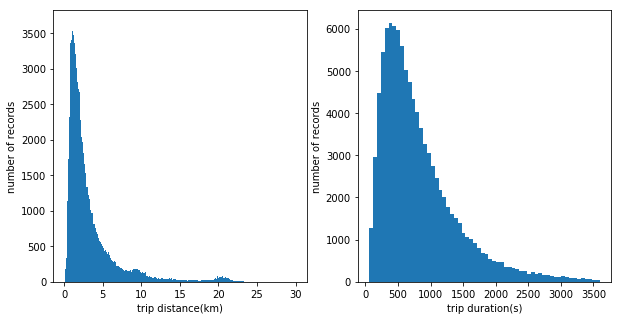

In [21]:
#plot two histograms, one for the relationship between haversine distance and number of record
#the other for the relationship between trip duration and number of record
fig, ax = plt.subplots(1, 2, figsize=(10,5))

n, bins_limits, patches = ax[0].hist(data['hav_distance'].values, bins=300)
ax[0].set_xlabel('trip distance(km)')
ax[0].set_ylabel('number of records')

n_, bins_limits_, patches_ = ax[1].hist(data['trip_duration'].values, bins=60)
ax[1].set_xlabel('trip duration(s)')
ax[1].set_ylabel('number of records')

plt.show()

In [0]:
# # To have a look at the values of histgrams
# for a,b in enumerate(patches):
#     print('Histgram values of trip distance', a,b)
# for a,b in enumerate(patches_):
#     print('Histgram values of trip duration',a,b)

**Observations:**
- If we have a look at the histgram of our preprocessed data, the shape of either distribution is similar to a gamma distribution. 
- The most frequent distance of the trip is around 1km, rougly distributed within range of 0 to 5 km; and most frequent trip duration is around 400s, roughly distributed within range of 100 to 1500 s. 

[Text(0, 0.5, 'Trip Duration(s)'), Text(0.5, 0, 'Haversine Distance(km)')]

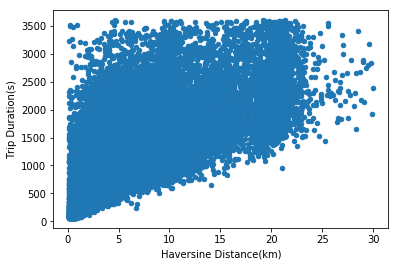

In [33]:
#plot the relationship about haversine distance to trip duration
ax_ = data.plot(x='hav_distance',y='trip_duration',kind='scatter')
ax_.set(xlabel='Haversine Distance(km)',ylabel='Trip Duration(s)')

**Observations:**
- The scatter plot is an approximate banding pattern. The region with more densely clustered points represents the general cases. When distance is below around 24km, the points are dense, when distance is above around 24km, the points become sparse.
- The trip duration is linearly and positively correlated with Haversine distance. The bottom of scatter is roughly linear with slope 0.015km/s (55.2km/h), which might indicate that the there exists a upper limit of speed of travelling. The upper boundary seems blurred, which might imply various non-straight-forward routine.

### Correlation

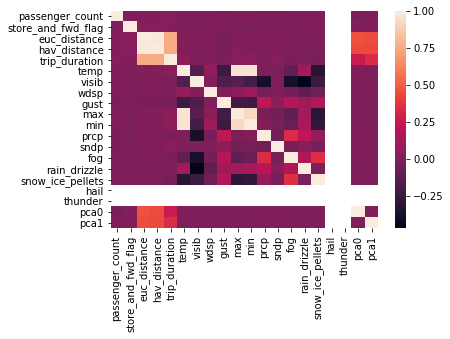

In [34]:
#plot the confusion matrix to show the correlation amoung features
tmp = data[data.columns[data.dtypes!='uint8']]
tmp = tmp[tmp.columns[tmp.dtypes!='int32']]
corr = tmp.corr()
sns.heatmap(corr)

**Observations:**
- The most correlated features are 2 'distance' and 2 'pca'.
- Many features of the weather data have obvious correlations with each others.

### Trip Frequency

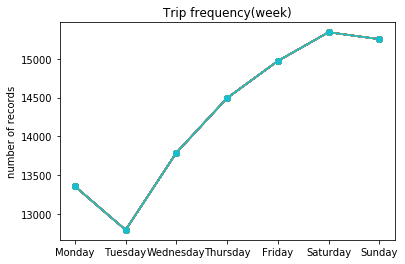

In [36]:
#plot the trip frequency over one week period
weekDays = ("Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")

plt.plot(df.groupby('day').count(),'o-')
plt.title('Trip frequency(week)')
plt.ylabel('number of records')
plt.xticks(np.arange(1,8),weekDays)
plt.show()

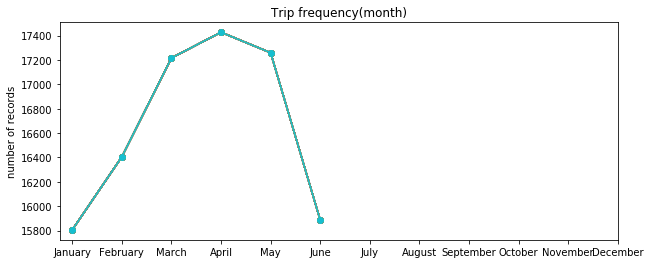

In [37]:
#plot the trip frequency over one month period for first half of 2016
plt.figure(figsize=(10, 4))
plt.plot(df.groupby('month').count(),'o-')
plt.title('Trip frequency(month)')
plt.ylabel('number of records')
plt.xticks(np.arange(1,13), calendar.month_name[1:13])
plt.show()

**Observations:**
- Data for both weekday and month are unevenly distributed. 
- Saturday sees the most frequent taxi trips, and Tuesday sees the least.
- For month information, there is only data from January to June. And May sees the most frequent taxi trips.

### Start and end point distribution

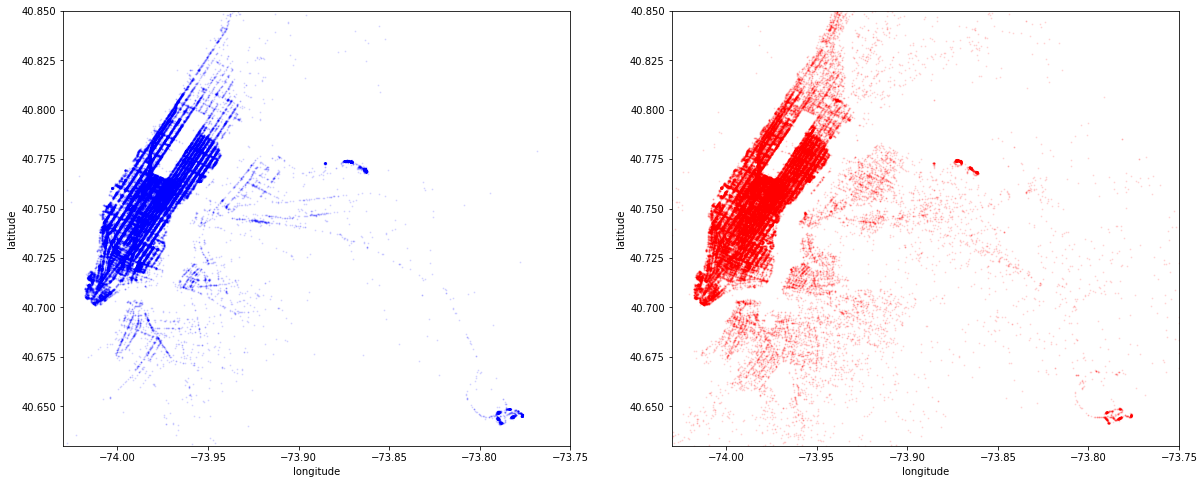

In [38]:
#plot the pickup and dropoff location interms of latitude and longitude
plt.figure(figsize=(20,8))
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.subplot(121)
plt.scatter(df['pickup_longitude'].values[:len(data)], df['pickup_latitude'].values[:len(df)],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.subplot(122)
plt.scatter(df['dropoff_longitude'].values[:len(data)], df['dropoff_latitude'].values[:len(df)],
              color='red', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

Text(0.5, 1.0, 'PCA')

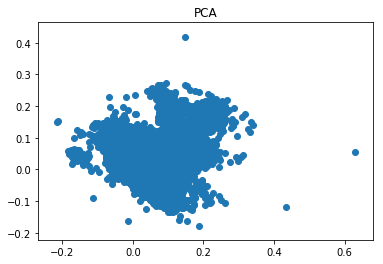

In [53]:
#plot the data after PCA
plt.scatter(data['pca0'].values,data['pca1'].values)
plt.title('PCA')

**Observations:** （不会）
- From scatter plot, the most popular fetch areas are Manhattan and two airports.
- From principle component analysis, the direction of maximum variance...

## Model Selection

## overall result of three model we used:##
|Model|Score|Advanage|Disadvantage|
|---|---|---|---|
|**XGBoost**|0.75||
|**Linear Regression**|0.63||
|**Random Forest**|0.65||

In [0]:
#drop the trip duration 
X = data.drop('trip_duration',axis=1)
#use trip duration as prediction objective
Y = data['trip_duration']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=0)

### XGBoost

**Model Features:**
- Gradient Boosting algorithm. 
- Stochastic Gradient Boosting with sub-sampling at the row, column and column per split levels.
- Regularized Gradient Boosting with both L1 and L2 regularization.

In [0]:
'''
Root Mean Squared Logarithmic Error (RMSLE):
If both real and predicted values are huge, RMSLE 
avoid penalizing huge differences between their values.
'''
#define function for calculating root mean square log error
def rmsle(real, predicted):
    sum=0.0
    for x in range(len(predicted)):
        if predicted[x]<0 or real[x]<0: #check for negative values
            continue
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [42]:
#set up the data for XGB model
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_val, label=Y_val)
dtest = xgb.DMatrix(X_test)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
#set up the parameters for XGB data
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [43]:
#execute the XGB model, and apply early stop mechanism
xgb_model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=10)

[0]	train-rmse:746.751	valid-rmse:747.171
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:321.927	valid-rmse:337.538
[20]	train-rmse:285.21	valid-rmse:308.07
[30]	train-rmse:272.11	valid-rmse:301.677
[40]	train-rmse:263.438	valid-rmse:297.984
[50]	train-rmse:257.834	valid-rmse:295.937
[60]	train-rmse:254.059	valid-rmse:295.411
[70]	train-rmse:252.119	valid-rmse:295.059
[80]	train-rmse:248.386	valid-rmse:294.325
[90]	train-rmse:246.219	valid-rmse:293.872
[100]	train-rmse:244.018	valid-rmse:294.053
[110]	train-rmse:241.14	valid-rmse:293.972
[120]	train-rmse:238.797	valid-rmse:294.385
[130]	train-rmse:235.911	valid-rmse:294.107
[140]	train-rmse:234.081	valid-rmse:293.735
[150]	train-rmse:232.44	valid-rmse:293.735
[160]	train-rmse:230.775	valid-rmse:293.845
[170]	train-rmse:228.572	valid-rmse:294.198
[180]	train-rmse:226.93	valid-rmse:294.26
[190]	train-rmse:224.473	valid-rmse:2

In [48]:
#display the r square, RMSE, and RMSLE score for XGB model
Y_pred = xgb_model.predict(dtest)
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

,R2,RMSE,RMSLE
0,0.748529,294.256242,0.400255


In [49]:
#generate feature importance table to see which feature has higher importance in prediction
feature_importance_dict = xgb_model.get_fscore()

feature_importance = pd.DataFrame({'feature name':list(feature_importance_dict.keys()),
                                   'importance':list(feature_importance_dict.values())})

feature_importance.sort_values(by='importance', ascending=False)

,feature name,importance
25,pca0,2284
1,pca1,2217
13,euc_distance,2052
0,hav_distance,1718
34,temp,1209
2,min,1061
14,wdsp,999
36,max,910
40,visib,755
3,gust,527


from the table we can see that the PCA has highest feature importance, then followed by two distance. this make sense since distance is heavily correlated to trip duration

### Linear Regression

In [50]:
#apply linear regression model to the data
linear_model = LinearRegression()
linear_model.fit(X_train,Y_train)
#display the r square, RMSE, and RMSLE score for linear regression model
Y_pred = linear_model.predict(X_test)
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

,R2,RMSE,RMSLE
0,0.632128,355.901929,0.484851


### Random Forest Model

In [51]:
#apply random forest model to the data
rf_model = RandomForestRegressor(n_estimators=100, random_state=0, max_depth=5)
rf_model.fit(X_train,Y_train)
#display the r square, RMSE, and RMSLE score for random forest model
Y_pred = rf_model.predict(X_test)
r2_v = r2_score(Y_test,Y_pred)
rmse_v = math.sqrt(mean_squared_error(Y_test,Y_pred))
rmsle_v = rmsle(Y_test.values,Y_pred)

pd.DataFrame({'R2':[r2_v],'RMSE':[rmse_v],'RMSLE':[rmsle_v]})

,R2,RMSE,RMSLE
0,0.655288,344.516421,0.428923


## conclusion:

we found that XGB model actualy has highest prediction accuracy in terms of r square, RMSE and RMSLE score among three models we apply.